#Interpolate Initial field in NEMO

This notebook inerpolated the regular x-y grid Ba (calculated in [Barium] 03) into ORCA2 and ANHA4 tri-polar grid.

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
import sys
sys.path.insert(0, '_libs/')

In [10]:
import glob
#import pyproj
import scipy.io
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic
% matplotlib inline

In [11]:
from NEMO_tools import int_profile, bin_profile, find_inland, reporj_NEMOgrid

In [12]:
from pykrige.ok import OrdinaryKriging
import pykrige.kriging_tools as kt

#ORCA2

In [15]:
MAT = scipy.io.loadmat('_data/Exchange/Temp_Ba_int_ANHA4.mat')
Ba_ini_xy = MAT['Ba_ini_xy'][:]
#nav_lat = MAT['nav_lat'][:]
#nav_lon = MAT['nav_lon'][:]
coordinate_name=glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ORCA2_LIM_nemo_v3.4/coordinates*.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]

In [16]:
lon_list = np.linspace(-180, 180, 360)
lat_list = np.linspace(60, 90, 30)
lonxy, latxy = np.meshgrid(lon_list, lat_list)

In [17]:
num_layer = 31
curent_layer = 27

In [18]:
Ba_ini_orca = np.empty([num_layer, np.size(nav_lon, 0), np.size(nav_lon, 1)])

In [19]:
for i in range(curent_layer):
    int_temp_orca = reporj_NEMOgrid(lonxy, latxy, Ba_ini_xy[:, :, i], nav_lon, nav_lat, method='linear')
    int_temp_mask = reporj_NEMOgrid(lonxy, latxy, Ba_ini_xy[:, :, i], nav_lon, nav_lat, method='nearest')
    int_temp_orca[np.isnan(int_temp_orca)] = int_temp_mask[np.isnan(int_temp_orca)]
    Ba_ini_orca[i, :, :] = int_temp_orca

In [20]:
for i in range(curent_layer, num_layer):
    Ba_ini_orca[i, :, :] = Ba_ini_orca[curent_layer-1, :, :]

In [21]:
Ba_ini_masked = np.ma.masked_where(np.isnan(Ba_ini_orca), Ba_ini_orca)

In [22]:
ETOPO2_Arctic=scipy.io.loadmat('_libs/ETOPO2_Arctic.mat')
lon_arctic=ETOPO2_Arctic['lon_arctic']
lat_arctic=ETOPO2_Arctic['lat_arctic']
topo_arctic=ETOPO2_Arctic['topo_arctic']

In [23]:
# Adjust resolution
res_unit=5
lon_arctic=lon_arctic[0:-1:res_unit, 0:-1:res_unit]
lat_arctic=lat_arctic[0:-1:res_unit, 0:-1:res_unit]
topo_arctic=topo_arctic[0:-1:res_unit, 0:-1:res_unit]*-1

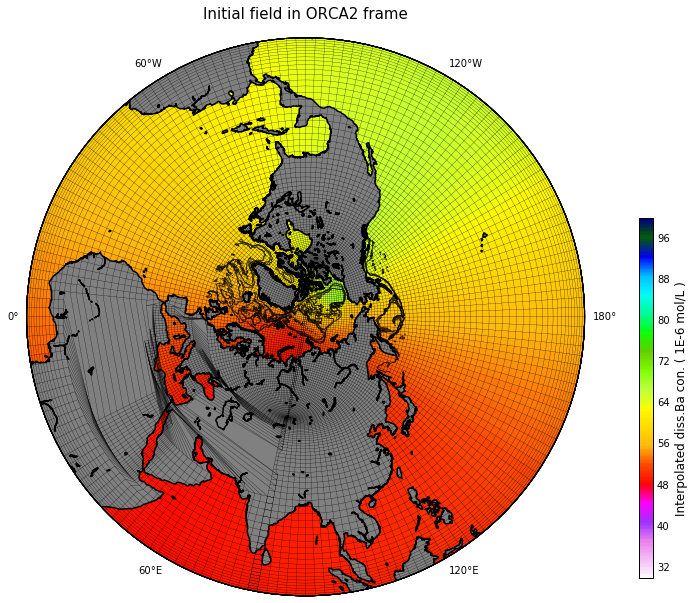

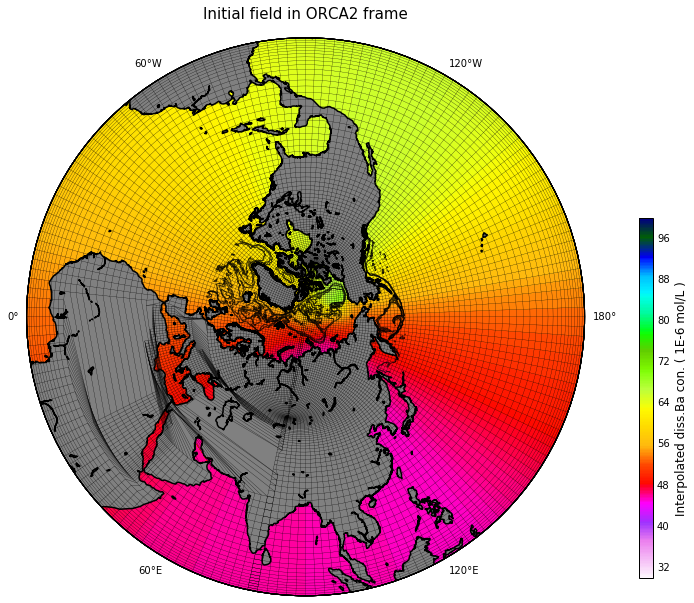

In [24]:
clevs=[1000, 2000, 3000]
for num in range(2):
    # Figures
    fig=plt.figure(figsize=(10, 10)); ax=plt.gca()
    proj=Basemap(projection='npstere', resolution='l', boundinglat=0, lon_0=90, round=True, ax=ax)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
    proj.drawcoastlines(linewidth=1.5, color='k')
    gridx, gridy = proj(nav_lon, nav_lat)
    topox, topoy = proj(lon_arctic, lat_arctic)
    CS = proj.pcolor(gridx, gridy, Ba_ini_masked[num, :, :], vmin=30, vmax=100, cmap=plt.cm.gist_ncar_r)
    CS2 = proj.contour(topox, topoy, topo_arctic, clevs, linestyles='-', linewidths=1, colors=('k',), alpha=0.75)
    CS2.collections[0].set_label('1, 2, 3 km bathymetry')
    proj.plot(gridx.T, gridy.T, 'k-', lw=0.25)
    proj.plot(gridx, gridy, 'k-', lw=0.25)
    cbaxes = fig.add_axes([0.975, 0.15, 0.02, 0.5]) 
    CBar = plt.colorbar(CS, ax=ax, cax=cbaxes) 
    CBar.set_label('Interpolated diss.Ba con. ( 1E-6 mol/L )', fontsize=12)
    CBar.ax.tick_params(axis='y', length=0)
    ax.set_title('Initial field in ORCA2 frame', fontsize=15, y=1.025)

In [38]:
# Save
save_var = { 'Ba_ini_orca': Ba_ini_orca, 'nav_lon': nav_lon, 'nav_lat': nav_lat}
scipy.io.savemat('_data/Exchange/NEMO_ORCA2_Ba.mat', mdict=save_var)

#ANHA4

In [26]:
ANHA4_MAT=scipy.io.loadmat('_data/Exchange/coord_ANHA4.mat')
ANHA4_lon=ANHA4_MAT['nav_lon']
ANHA4_lat=ANHA4_MAT['nav_lat']

In [27]:
ANHA4_lon.shape

(544, 800)

In [29]:
MAT = scipy.io.loadmat('_data/Exchange/Temp_Ba_int_ANHA4.mat')
Ba_ini_xy = MAT['Ba_ini_xy'][:]
#nav_lat = MAT['nav_lat'][:]
#nav_lon = MAT['nav_lon'][:]

In [30]:
num_layer = 50
curent_layer = 45

In [31]:
Ba_ini_ANHA4 = np.empty([num_layer, np.size(ANHA4_lon, 0), np.size(ANHA4_lon, 1)])

In [32]:
for i in range(curent_layer):
    int_temp_ANHA4 = reporj_NEMOgrid(lonxy, latxy, Ba_ini_xy[:, :, i], ANHA4_lon, ANHA4_lat, method='linear')
    int_temp_mask = reporj_NEMOgrid(lonxy, latxy, Ba_ini_xy[:, :, i], ANHA4_lon, ANHA4_lat, method='nearest')
    int_temp_ANHA4[np.isnan(int_temp_ANHA4)] = int_temp_mask[np.isnan(int_temp_ANHA4)]
    Ba_ini_ANHA4[i, :, :] = int_temp_ANHA4

In [33]:
for i in range(curent_layer, num_layer):
    Ba_ini_ANHA4[i, :, :] = Ba_ini_ANHA4[curent_layer-1, :, :]

In [34]:
Ba_ini_masked = np.ma.masked_where(np.isnan(Ba_ini_ANHA4), Ba_ini_ANHA4)

In [35]:
Ba_ini_ANHA4[0, 1, 350]

64.944882508549227

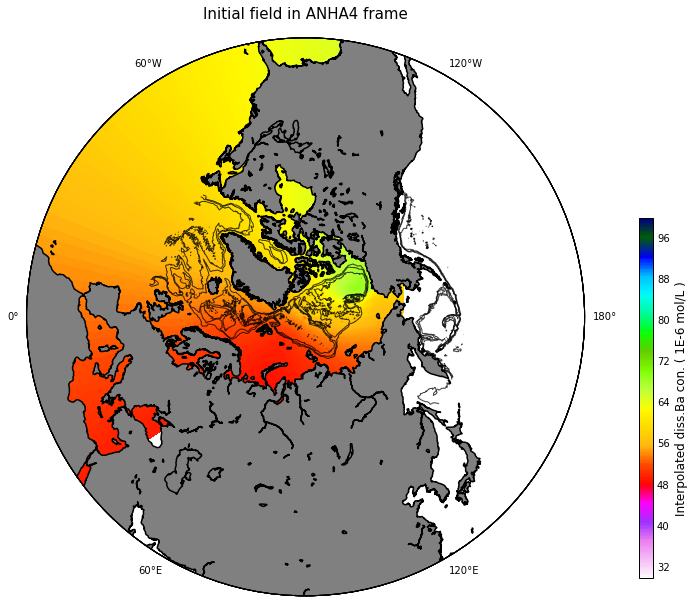

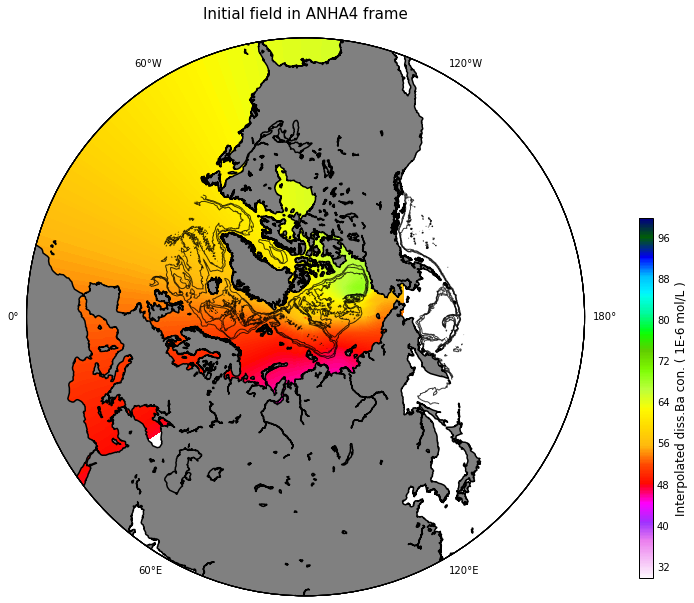

In [36]:
clevs=[1000, 2000, 3000]
for num in range(2):
    # Figures
    fig=plt.figure(figsize=(10, 10)); ax=plt.gca()
    proj=Basemap(projection='npstere', resolution='l', boundinglat=25, lon_0=90, round=True, ax=ax)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
    proj.fillcontinents(color=[0.5, 0.5, 0.5], lake_color=None)
    proj.drawcoastlines(linewidth=1.5, color='k')
    gridx, gridy = proj(ANHA4_lon, ANHA4_lat)
    topox, topoy = proj(lon_arctic, lat_arctic)
    CS = proj.pcolor(gridx, gridy, Ba_ini_masked[num, :, :], vmin=30, vmax=100, cmap=plt.cm.gist_ncar_r)
    CS2 = proj.contour(topox, topoy, topo_arctic, clevs, linestyles='-', linewidths=1, colors=('k',), alpha=0.75)
    CS2.collections[0].set_label('1, 2, 3 km bathymetry')
    #proj.plot(gridx.T, gridy.T, 'k-', lw=0.25)
    #proj.plot(gridx, gridy, 'k-', lw=0.25)
    cbaxes = fig.add_axes([0.975, 0.15, 0.02, 0.5]) 
    CBar = plt.colorbar(CS, ax=ax, cax=cbaxes) 
    CBar.set_label('Interpolated diss.Ba con. ( 1E-6 mol/L )', fontsize=12)
    CBar.ax.tick_params(axis='y', length=0)
    ax.set_title('Initial field in ANHA4 frame', fontsize=15, y=1.025)

In [39]:
# Save
save_var = { 'Ba_ini_ANHA4': Ba_ini_ANHA4, 'nav_lon': ANHA4_lon, 'nav_lat': ANHA4_lat}
scipy.io.savemat('_data/Exchange/NEMO_ANHA4_Ba.mat', mdict=save_var)